### Install tendb
Must install latest tendb before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ tendb
```
Read local setup.py and install tendb
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/tendb
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/tendb/dist/tendb-0.0.1-py3-none-any.whl
```

Using Apache Arrow columnar storage. Import pyarrow libraries.

In [1]:
import pyarrow as pa
from pyarrow import csv

Get a Liten Cache Instance

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten._liten' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Add table wrapper from Liten. Uses pyarrow calls to add table

Under dev error reading read_csv reading about positional vs keyword arguments, pas.csv.read_csv compains TODO

In [14]:
import functools
from functools import wraps

class LCache:
    
    def __init__(self):
        """ Create a new cache """
        self.lc = ten.new_cache()
        self.num_table = 0
        self.table_name = "_t" + str(self.num_table);
    
    def set_table(self, table_name):
        """ Default table names are _t<table_num> 
        set_table(table_name) sets table name to table_name for next csv reader """
        self.table_name = table_name
    
    def read_csv(self, *args, **kwargs):
        """ Read arrow csv table using pyarrow.csv.read_csv arrow functions
        All the arguments are directly passed to the arrow function"""
        arrow_table = pa.csv.read_csv(*args, **kwargs)
        self.lc.add_table(self.table_name, arrow_table)
        added_table_name = self.table_name
        self.num_table += 1
        self.table_name = "_t" + str(self.num_table)
        return added_table_name
            

In [15]:
tc = LCache()

def read_table(table_name, input_file):
    tc.set_table(table_name)
    csv_options = pa.csv.ParseOptions(delimiter='|')
    arrow_table = tc.read_csv(input_file, parse_options=csv_options)
    return arrow_table

Added a new cache


Read a table into TCache/

In [16]:
def get_tpch_tables():
    table_names = ['lineitem','customer','orders','supplier','nation','region']
    tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sfdot001g/'
    #tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'
    tpch_tables = []
    for table_name in table_names:
        tpch_tables.append(tpch_dir+table_name+'.tbl')
    return tpch_tables

btable_names = [b'lineitem',b'customer',b'orders',b'supplier',b'nation',b'region']

def read_tpch_tables(tpch_tables):
    arrow_tpch_tables = []
    for i in range(len(tpch_tables)):
        arrow_table=read_table(table_name=btable_names[i], input_file=tpch_tables[i])
        arrow_tpch_tables.append(arrow_table)
    return arrow_tpch_tables

Read Arrow table

In [17]:
%%time
arrow_tpch_tables = read_tpch_tables(get_tpch_tables())

Failed to add table= b'lineitem'
Failed to add table= b'customer'
Failed to add table= b'orders'
Failed to add table= b'supplier'
Failed to add table= b'nation'
Failed to add table= b'region'
CPU times: user 8.16 ms, sys: 32.6 ms, total: 40.8 ms
Wall time: 70 ms


In [7]:
for i in range(len(arrow_tpch_tables)):
    print(btable_names[i]," Rows=", arrow_tpch_tables[i].num_rows," Cols=", arrow_tpch_tables[i].num_columns)

b'lineitem'  Rows= 6005  Cols= 16
b'customer'  Rows= 150  Cols= 8
b'orders'  Rows= 1500  Cols= 9
b'supplier'  Rows= 10  Cols= 7
b'nation'  Rows= 25  Cols= 4
b'region'  Rows= 5  Cols= 3


Liten sample commands

In [8]:
tc.lc.info()

Workers=6


b'[region,customer,lineitem,orders,supplier,nation,]'

In [10]:
%%time
bdim_table_names = [b'customer',b'orders',b'supplier',b'nation',b'region']
for table in bdim_table_names:
    result = tc.lc.make_dtensor(table)
    print(table,"=",result)

b'customer' = 0
b'orders' = 0
b'supplier' = 0
b'nation' = 0
b'region' = 0
CPU times: user 12.5 ms, sys: 1.81 ms, total: 14.3 ms
Wall time: 9.26 ms


 TPCH QUERY 6 
SELECT 
  SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
FROM 
  LINEITEM
WHERE
  L_SHIPDATE >= DATE '1997-01-01'
  AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
  AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
  AND L_QUANTITY < 25;

Revenue= 125257.80519999999



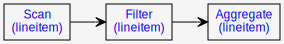

In [11]:
tc.lc.query6()

 
SELECT
	N_NAME,
	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
FROM
	CUSTOMER,
	ORDERS,
	LINEITEM,
	SUPPLIER,
	NATION,
	REGION
WHERE
	C_CUSTKEY = O_CUSTKEY
	AND L_ORDERKEY = O_ORDERKEY
	AND L_SUPPKEY = S_SUPPKEY
	AND C_NATIONKEY = S_NATIONKEY
	AND S_NATIONKEY = N_NATIONKEY
	AND N_REGIONKEY = R_REGIONKEY
	AND R_NAME = 'EUROPE'
	AND O_ORDERDATE >= DATE '1995-01-01'
	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
GROUP BY
	N_NAME
ORDER BY
	REVENUE DESC;

b'UNITED KINGDOM' = 2132282.584500001



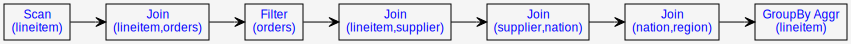

In [12]:
tc.lc.query5()